# Amazon fine food review

Downloaded from https://www.kaggle.com/snap/amazon-fine-food-reviews
The amazon fine food review dataset consists of review of fine foods on amazon .
- Number of reviews: 568,454
- Number of users: 256,059
- Number of products: 74,258
- Timespan: Oct 1999 - Oct 2012
- Number of Attributes/Columns in data: 10

Attribute Information:

- Id
- ProductId - unique identifier for the product
- UserId - unqiue identifier for the user
- ProfileName
- HelpfulnessNumerator - number of users who found the review helpful
- HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
- Score - rating between 1 and 5
- Time - timestamp for the review
- Summary - brief summary of the review
- Text - text of the review
### Objective
To determine whether the review given is positive(score rating of 4 or 5 stars) or negative(score rating of 1 or 2 stars).

## Loading the data
The dataset is available in two formats i.e.
1. sqlite database
2. .csv file
We will load data using SQLITE database as it is easier to give commands and visualise the data.

Here we only want to get the sentiment of th review(positive or negative). We will purposely remove the score of 3 and give a positive rating if the score is more than 3 and a negative rating if it is less than 3.

In [2]:
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns

# [1]. Reading the data


In [3]:
#loading dataset from sqlite database
con = sqlite3.connect('database.sqlite') 
# We are removing data points where score is equal to 3 as it cannot be predicted as positive or negative
filtered_data = pd.read_sql_query("""SELECT * FROM Reviews WHERE score != 3""", con )
def partition(x) :
    if x > 3 :
        return 'Positive'
    else :
        return 'Negative'

In [4]:
actualscore = filtered_data['Score']
positiveNegative = actualscore.map(partition)
filtered_data['Score'] = positiveNegative
print("No of data points", filtered_data.shape)
print(filtered_data.head())

No of data points (525814, 10)
   Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator     Score        Time  \
0                     1                       1  Positive  1303862400   
1                     0                       0  Negative  1346976000   
2                     1                       1  Positive  1219017600   
3                     3                       3  Negative  1307923200   
4                     0                       0  Positive  1350777600   

                 Summary                                               Text  
0  Good Quality Dog Food  I hav

## Exploratory Data Analysis
## [2] Data Cleaning(Deduplication)
It is observed that the data has many duplicate entries. Hence it is necessary to remove dupliactes in order to get unbiased results.

In [5]:
#sorting data in according to ProductId
#sorted_data= filtered_data.sort_values('ProductId', axis =0 , ascending = True, inplace=False, kind ='quicksort', na_position='last')
#print(sorted_data.head())

            Id   ProductId          UserId                  ProfileName  \
138706  150524  0006641040   ACITT7DI6IDDL              shari zychinski   
138688  150506  0006641040  A2IW4PEEKO2R0U                        Tracy   
138689  150507  0006641040  A1S4A3IQ2MU7V4        sally sue "sally sue"   
138690  150508  0006641040     AZGXZ2UUK6X  Catherine Hallberg "(Kate)"   
138691  150509  0006641040  A3CMRKGE0P909G                       Teresa   

        HelpfulnessNumerator  HelpfulnessDenominator     Score        Time  \
138706                     0                       0  Positive   939340800   
138688                     1                       1  Positive  1194739200   
138689                     1                       1  Positive  1191456000   
138690                     1                       1  Positive  1076025600   
138691                     3                       4  Positive  1018396800   

                                           Summary  \
138706                   E

In [6]:
final = filtered_data.drop_duplicates(subset = {'UserId', 'ProfileName', 'Time','Text' }, keep = 'first', inplace=False)
print(final.head())
print(final.shape)

   Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator     Score        Time  \
0                     1                       1  Positive  1303862400   
1                     0                       0  Negative  1346976000   
2                     1                       1  Positive  1219017600   
3                     3                       3  Negative  1307923200   
4                     0                       0  Positive  1350777600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitalit

**Observation:** It was also observed in our data that some values have more value of HelpfulnessNumerator than HelpfulnessDenominator which is not possible so we will also clean those values

In [7]:
#removing values with HelpfulnessNumerator>HelpfulnessDenominator
final = final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
print(final.shape)
print(final['Score'].value_counts())

(364171, 10)
Positive    307061
Negative     57110
Name: Score, dtype: int64


## [3] Text Preprocessing
Now that we have removed the deduplicated from our dataset we need to perform some preprocessing operations before we go for further analysis and make the prediction model.

Hence in the preprocessing phase we do the following preprocessing in the order below:
1. Begin by removing HTML tags.
2. Remove any punctuation or limited set of special characters like . , # etc.
3. Check if the word is made up of English characters and is alpha-numeric.
4. Remove the words having size less than 3 (as in English vocabulary no adjective has size less than 3).
5. Convert words to lowercase.
6. Remove all Stopwords.
7. Finally Snowball Stemming the words .(As it was observed that it was better than Porter Stemming)


In [8]:
import re # regular expressions
import string
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english'))# set of English Stopwords
sno = nltk.stem.SnowballStemmer('english')# initialising the snowball stemmer

def cleanhtml(sentence): #function to clear HTML tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext

def cleanpunc(sentence):
    cleaned = re.sub(r'[?|!|\'|"|#]', ' ', sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]', ' ', cleaned)
    return cleaned
print(stop)
    

{'here', 'in', 'just', 'at', 'themselves', 'before', "you've", 'ours', "should've", 'with', 'was', 'until', 'above', 'when', "shan't", 'have', 've', 'as', 'once', 'who', 'very', 'shan', 'should', 'under', 'against', 'then', 'doing', 'over', 'the', "don't", "that'll", "mustn't", 'ma', 'wouldn', 'they', 'couldn', 'didn', "haven't", "weren't", 'some', 'll', "hasn't", 'this', 'weren', 'won', 'too', 'that', 'nor', 'from', 'don', 'how', 'my', 'y', 'why', 'no', "shouldn't", "aren't", 'further', 'yours', 'yourselves', 'hasn', "she's", 's', "you'll", 'more', 'each', 'myself', 'needn', 'he', 'own', 'd', "doesn't", 'it', 'being', 'only', 'ain', 'between', 'during', 'by', 'not', 'off', 'mustn', "it's", 'his', 'haven', 'been', 'are', 'for', "couldn't", 'hadn', 'same', 'do', 'has', 'to', 'and', 'had', 'there', 'both', 'our', 'having', 'were', 'did', 'up', 'o', 'few', 'such', 'can', 'yourself', 'she', 'of', 'their', 'its', 'isn', 'or', 'any', "wasn't", 'is', 'most', 'does', 'where', "wouldn't", 'out'

In [9]:
#code to implement all the preprocessing
from tqdm import tqdm
i =0 
strl = ' '
final_string= []
all_postive_words = []#stores all positive words
all_negative_words = []#stores all negative words
s = ''
for sent in tqdm(final['Text'].values) :
    filtered_sentence = []
    sent = cleanhtml(sent)
    for w in sent.split() :
        for cleaned_words in cleanpunc(w).split() :
            if ((cleaned_words.isalpha()) & ((len(cleaned_words))>2)) :
                if (cleaned_words.lower() not in stop) :
                    s = (sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'postive':
                        all_positive_words.append(s)
                    if (final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s)
                else :
                    continue
            else : 
                continue
    strl = b" ".join(filtered_sentence) #final string of all cleared words

    final_string.append(strl)
    i+=1
    


100%|█████████████████████████████████████████████████████████████████████████| 364171/364171 [19:11<00:00, 316.16it/s]


In [10]:
print(final_string[0:5])

[b'bought sever vital can dog food product found good qualiti product look like stew process meat smell better labrador finicki appreci product better', b'product arriv label jumbo salt peanut peanut actual small size unsalt sure error vendor intend repres product jumbo', b'confect around centuri light pillowi citrus gelatin nut case filbert cut tini squar liber coat powder sugar tini mouth heaven chewi flavor high recommend yummi treat familiar stori lewi lion witch wardrob treat seduc edmund sell brother sister witch', b'look secret ingredi robitussin believ found got addit root beer extract order good made cherri soda flavor medicin', b'great taffi great price wide assort yummi taffi deliveri quick taffi lover deal']


In [11]:
final['CleanedText'] = final_string

print(final.head(3))

#store final table into a SQLlite table for future use
conn =sqlite3.connect('final.sqlite')
c = conn.cursor()
conn.text_factory = str
final.to_sql('Reviews',conn, schema = None, if_exists='replace')

   Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   

   HelpfulnessNumerator  HelpfulnessDenominator     Score        Time  \
0                     1                       1  Positive  1303862400   
1                     0                       0  Negative  1346976000   
2                     1                       1  Positive  1219017600   

                 Summary                                               Text  \
0  Good Quality Dog Food  I have bought several of the Vitality canned d...   
1      Not as Advertised  Product arrived labeled as Jumbo Salted Peanut...   
2  "Delight" says it all  This is a confection that has been around a fe...   

                                         CleanedText  
0  b'bought sever vital can dog food product foun...  

## [4] Featurization
## [4.1] Bag of Words


In [82]:
from sklearn.feature_extraction.text import CountVectorizer #BoW
count_vect = CountVectorizer()
final_counts = count_vect.fit_transform(final['CleanedText'].values)

print(final_counts.get_shape())


(364171, 120723)


In [84]:
print(type(final_counts))
print(final_counts[0])

<class 'scipy.sparse.csr.csr_matrix'>
  (0, 117675)	1
  (0, 60672)	1
  (0, 11819)	3
  (0, 62546)	1
  (0, 97004)	2
  (0, 58942)	1
  (0, 61443)	1
  (0, 85911)	2
  (0, 16328)	1
  (0, 32178)	1
  (0, 2701)	1
  (0, 2987)	1
  (0, 94666)	1
  (0, 86384)	1
  (0, 49498)	1
  (0, 59196)	1
  (0, 116471)	1
  (0, 52751)	1
  (0, 32228)	1
  (0, 61493)	1
  (0, 70186)	1
  (0, 118095)	1
  (0, 53942)	1
  (0, 94460)	1
  (0, 20758)	1
  (0, 117257)	1
  (0, 9770)	1
  (0, 99775)	1
  (0, 131)	1
  (0, 64900)	1
  (0, 22103)	1


## [4.2] Bi-Grams and N-Grams


In [16]:
count_vect = CountVectorizer(ngram_range=(1,2), max_features = 5000)
final_bigram_counts = count_vect.fit_transform(final['CleanedText'].values)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (364171, 5000)
the number of unique words including both unigrams and bigrams  5000


In [18]:
print(count_vect.get_feature_names()[0:10])

['abil', 'abl', 'abl buy', 'abl eat', 'abl find', 'abl get', 'abl order', 'abl purchas', 'absolut', 'absolut best']


## [4.3] TF-IDF

In [51]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf_vect = TfidfVectorizer(ngram_range = (1,2), max_features = 5000 )
tf_idf  = tf_idf_vect.fit_transform(final['CleanedText'].values)


## [4.4] Word2Vec


In [30]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
list_of_sentance = []
for sentance in tqdm(final['Text'].values) :
    filtered_sentence = []
    sentance = cleanhtml(sentance)
    for w in sentance.split() :
        for cleaned_words in cleanpunc(w).split() :
            if cleaned_words.isalpha() :
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue
    list_of_sentance.append(filtered_sentence)
            
print(list_of_sentance[0:10])


100%|████████████████████████████████████████████████████████████████████████| 364171/364171 [04:22<00:00, 1389.86it/s]


[['this', 'witty', 'little', 'book', 'makes', 'my', 'son', 'laugh', 'at', 'loud', 'i', 'recite', 'it', 'in', 'the', 'car', 'as', 'we', 're', 'driving', 'along', 'and', 'he', 'always', 'can', 'sing', 'the', 'refrain', 'he', 's', 'learned', 'about', 'whales', 'india', 'drooping', 'i', 'love', 'all', 'the', 'new', 'words', 'this', 'book', 'introduces', 'and', 'the', 'silliness', 'of', 'it', 'all', 'this', 'is', 'a', 'classic', 'book', 'i', 'am', 'willing', 'to', 'bet', 'my', 'son', 'will', 'still', 'be', 'able', 'to', 'recite', 'from', 'memory', 'when', 'he', 'is', 'in', 'college'], ['i', 'grew', 'up', 'reading', 'these', 'sendak', 'books', 'and', 'watching', 'the', 'really', 'rosie', 'movie', 'that', 'incorporates', 'them', 'and', 'love', 'them', 'my', 'son', 'loves', 'them', 'too', 'i', 'do', 'however', 'miss', 'the', 'hard', 'cover', 'version', 'the', 'paperbacks', 'seem', 'kind', 'of', 'flimsy', 'and', 'it', 'takes', 'two', 'hands', 'to', 'keep', 'the', 'pages', 'open'], ['this', 'is'

In [32]:
w2v_model = Word2Vec(list_of_sentance, min_count = 5, size = 50 , workers = 4 )

In [33]:
print(w2v_model.wv['tasty'])

[ 2.306777    1.5345569   1.4738575   1.2109184   0.3237689   1.2502356
 -1.9669654  -2.5789087  -0.8718345  -3.72842    -3.0737162   4.2523494
 -2.611674   -3.7128038  -1.7958862   1.6605666  -0.5132015  -2.1449482
  0.9159958  -3.2898467   1.0448121  -2.8066347   4.20469    -3.6532824
  1.8867563   1.5550915   1.5032315   1.5938083  -2.9014225   0.32717848
 -0.8834928  -1.8146671  -2.0568388  -0.5081258  -2.5150037   0.38287023
 -2.7327163   1.386892    0.25882074 -3.9397812   1.7526035   2.098924
  0.32649037  2.6182933  -1.1348414   2.8553622  -0.11310102 -1.5436605
 -3.4041698   0.7049724 ]


In [49]:
print(w2v_model.wv.most_similar('tasty'))

[('tastey', 0.9038693904876709), ('yummy', 0.8598141670227051), ('satisfying', 0.8526679277420044), ('filling', 0.8238525986671448), ('delicious', 0.8212383985519409), ('flavorful', 0.7999732494354248), ('addicting', 0.7610380053520203), ('nutritious', 0.751555323600769), ('delish', 0.7501494884490967), ('versatile', 0.7358132600784302)]


## [4.4] Average Word2Vec

In [38]:
sentance_vector = []
w2v_words = list(w2v_model.wv.vocab)
for sentance in list_of_sentance :
    sent_vector = np.zeros(50)
    cnt_words = 0
    for word in sentance :
        if word in w2v_words :
            vec = w2v_model.wv[word]
            sent_vector+=vec
            cnt_words +=1
        else :
            continue
    if cnt_words != 0:
        sent_vector = sent_vector/cnt_words
    sentance_vector.append(sent_vector)

print(len(sentance_vector))
print(len(sentance_vector[0]))
            
            
    

364171
50


## [4.4] TF-IDF weighted Word2Vec

In [57]:
tfidf_feat = tf_idf_vect.get_feature_names()
row = 0
tfidf_sent_vector = []
for sentance in tqdm(list_of_sentance):
    tfidf_sent_vec = np.zeros(50)
    weight_sum =0
    for word in sentance :
        if word in w2v_words and word in tfidf_feat :
            vec = w2v_model.wv[word]
            
            tfidf = tf_idf[row, tfidf_feat.index(word)]
            tfidf_sent_vec += (vec*tfidf)
            weight_sum +=tfidf
    if weight_sum != 0 :
        tfidf_sent_vec /=weight_sum
    tfidf_sent_vector.append(tfidf_sent_vec)
    row+=1

100%|████████████████████████████████████████████████████████████████████████| 364171/364171 [3:41:56<00:00, 27.35it/s]


In [48]:
print(len(tfidf_sent_vector))

364171


## [5] Data Visualization (Using t-SNE)

## [5.1] Applying t-SNE on Text BoW vectors

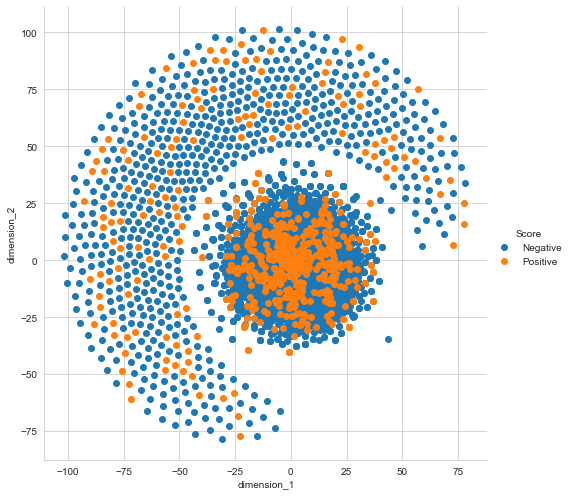

In [95]:
from sklearn.manifold import TSNE
from scipy.sparse import csr_matrix
from sklearn.preprocessing import StandardScaler

bow_final_4k = final_counts[0:4000]
score_4k = (final["Score"])[0:4000]

#standardising the BoW values to lie brtween 0 and 1
bow_final_4k = StandardScaler(with_mean=False).fit_transform(bow_final_4k)
#converting sparse matrix to dense matrix as t-SNE accepts only dense matrix
bow_final_4k = bow_final_4k.todense()  

tsne = TSNE(n_components = 2, random_state = 0 ) 
#default perplexity = 30
#default number of iterations = 1000

bow_tsne = tsne.fit_transform(bow_final_4k)

for_bow = np.vstack((bow_tsne.T, score_4k)).T
for_bow_df = pd.DataFrame(for_bow , columns = ('dimension_1', 'dimension_2', 'Score'))
sns.set_style('whitegrid')
sns.FacetGrid(for_bow_df, hue = 'Score',height = 7).map(plt.scatter, 'dimension_1', 'dimension_2').add_legend()
plt.show()

## [5.2] Applying t-SNE on Text TF-IDF vectors

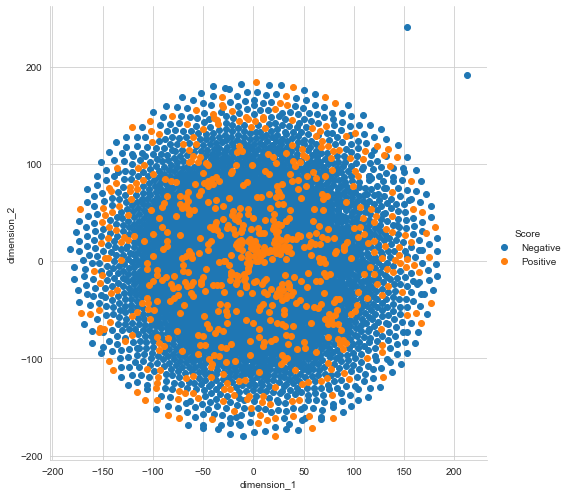

In [97]:
from sklearn.manifold import TSNE
from scipy.sparse import csr_matrix

tf_idf_4k = tf_idf[0:4000]
score_4k = final["Score"][0:4000]
tf_idf_4k = StandardScaler(with_mean = False).fit_transform(tf_idf_4k)
tf_idf_4k = tf_idf_4k.todense()

tsne = TSNE(n_components = 2, random_state = 0, perplexity = 50, n_iter=2000 ) 
#default perplexity = 30
#default number of iterations = 1000

tfidf_tsne = tsne.fit_transform(tf_idf_4k)

for_tfidf = np.vstack((tfidf_tsne.T, score_4k )).T
for_tfidf_df = pd.DataFrame(for_tfidf , columns = ('dimension_1', 'dimension_2', 'Score'))
sns.set_style('whitegrid')
sns.FacetGrid(for_tfidf_df, hue = 'Score',height = 7).map(plt.scatter, 'dimension_1', 'dimension_2').add_legend()
plt.show()

## [5.3] Applying t-SNE on  Text average Word2Vec 

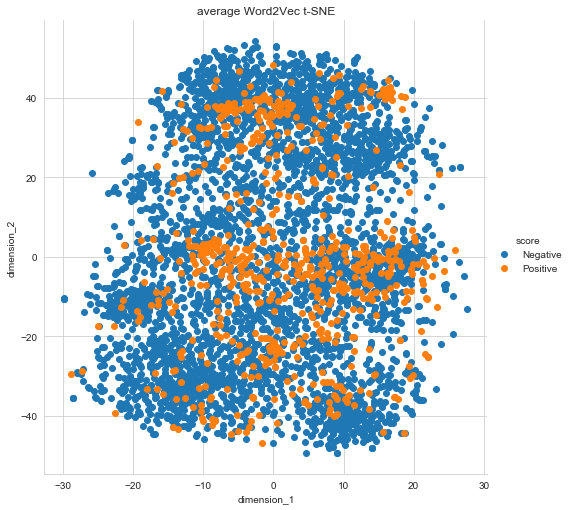

In [101]:
sentance_vector_4k = sentance_vector[0:4000]
sentance_vector_4k = StandardScaler(with_mean = False).fit_transform(sentance_vector_4k)

tsne = TSNE(n_components = 2 , random_state = 0, perplexity = 50 , n_iter=2000)

avgw2v_tsne = tsne.fit_transform(sentance_vector_4k)

for_avgw2v = np.vstack((avgw2v_tsne.T, score_4k)).T
avgw2v_df =pd.DataFrame(for_avgw2v, columns=('dimension_1', 'dimension_2', 'score'))

sns.set_style('whitegrid')
sns.FacetGrid(avgw2v_df, hue = 'score', height = 7).map(plt.scatter, 'dimension_1', 'dimension_2').add_legend()
plt.title('average Word2Vec t-SNE')
plt.show()


## [5.5] Applying t-SNE on Text TF-IDF weighted Word2Vec

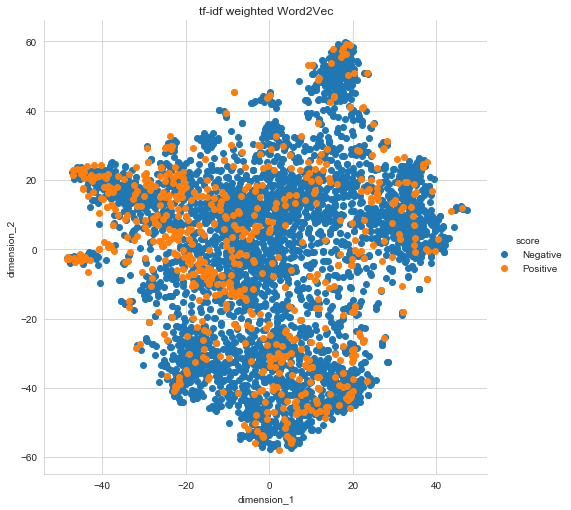

In [102]:
tfidf_sent_vector_4k = tfidf_sent_vector[0:4000]
tfidf_sent_vector_4k = StandardScaler(with_mean = False).fit_transform(tfidf_sent_vector_4k)

tsne = TSNE(n_components = 2 , random_state = 0, perplexity = 50 , n_iter=2000)
tfidf_w2v_tsne = tsne.fit_transform(tfidf_sent_vector_4k)

for_tfidf_w2v = np.vstack((tfidf_w2v_tsne.T, score_4k)).T
tfidf_w2v_df = pd.DataFrame(for_tfidf_w2v, columns=('dimension_1', 'dimension_2', 'score'))

sns.set_style('whitegrid')
sns.FacetGrid(tfidf_w2v_df, hue = 'score', height = 7).map(plt.scatter, 'dimension_1', 'dimension_2').add_legend()
plt.title('tf-idf weighted Word2Vec')
plt.show()

### Conclusion
1. None of the t-SNE plotted above gives a clear separation between positive and negative values.
2. We would have to use alternate methods to separate the values. 

In [114]:
#storing values for future use
final_avgw2v = pd.DataFrame(sentance_vector)
print(final_avgw2v.shape)

final_avgw2v.to_csv(r'D:\New folder\Practicals\amazon fine food\avgw2v.csv')



(364171, 50)


In [ ]:
final_tfidf_w2v = pd.DataFrame(tfidf_sent_vector)
print(final_tfidf_w2v.shape)

final_tfidf_w2v.to_csv(r'D:\New folder\Practicals\amazon fine food\tfidf_w2v.csv')

(364171, 50)
